# SIMCad Demos: Simple Tracker

# Configuration
We begin with a simple configuration file that only defines a single exogenous state: a sinusoidal `signal`

In [1]:
# SimCAD related imports
from datetime import timedelta
from SimCAD.configuration import Configuration
from SimCAD.configuration.utils import exo_update_per_ts, ep_time_step

# System specific imports
import numpy as np

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# List of all the states in the system and their initial conditions
# In the current version of SimCAD, `timestamp` is mandatory
# The `signal` state is the exogenous state that we'll model
initial_conditions = {
    'signal': float(0),
    'timestamp': '2018-01-01 00:00:00'
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Definitions of functions that update the exogenous states
# Functions must return a tuple containing the name of the state being updated and its new value
# For now, ignore all the arguments passed to the function, except `s`, 
# which contains a copy of the current values of all the states

# Definition of the function that updates the `timestamp` state
# In the current version of SimCAD, `timestamp` is a mandatory state
ts_format = '%Y-%m-%d %H:%M:%S'
t_delta = timedelta(days=0, minutes=0, seconds=1) # In this example, a time_step is defined as 1 second. The user can change this
def time_model(step, sL, s, _input):
    y = 'timestamp'
    x = ep_time_step(s, dt_str=s['timestamp'], fromat_str=ts_format, _timedelta=t_delta)
    return (y, x)

# Definition of the function that updates the `signal` state
# It's a simple sine wave with amplitude 1 and period 50 time_steps
period = 50
def sinusoid(step, sL, s, _input):
    y = 'signal'
    x = s['time_step']
    x = np.sin(x * 2 * np.pi / period)
    return (y, x)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# This maps the exogenous states to their corresponding updating functions
exogenous_states = exo_update_per_ts(
    {
    'signal': sinusoid, # The `signal` state is updated by the `sinusoid` function defined above
    'timestamp': time_model # The `timestamp` state is updated by the `time_model` function defined above
    }
)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is the number of discrete units of time the simulation will run for
# `N` is the number of times the simulation will be run
# In this example, we'll run the simulation once (N=1) and its duration will be of 50 discrete units of time
sim_config = {
    'T': range(50),
    'N': 1
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# We'll ignore these components of the configuration for now
env_processes = {}
seeds = {}
mechanisms = {}

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(sim_config=sim_config,
                       state_dict=initial_conditions,
                       seed=seeds,
                       exogenous_states=exogenous_states,
                       env_processes=env_processes,
                       mechanisms=mechanisms)

# Running the engine
We are now ready to run the engine with the configuration defined above. Instantiate an ExecutionMode, an ExecutionContext and an Executor objects, passing the Configuration object to the latter. Then run the `main()` method of the Executor object, which returns the results of the experiment in the first element of a tuple.

In [2]:
from SimCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.main() # The `main()` method returns a tuple; its first elements contains the raw results

single_proc: [<SimCAD.configuration.Configuration object at 0x10e17e160>]


# Analyzing the results
We can now convert the raw results into a DataFrame for analysis

count    5.100000e+01
mean    -2.493893e-17
std      7.071068e-01
min     -9.980267e-01
25%     -6.845471e-01
50%      0.000000e+00
75%      6.845471e-01
max      9.980267e-01
Name: signal, dtype: float64

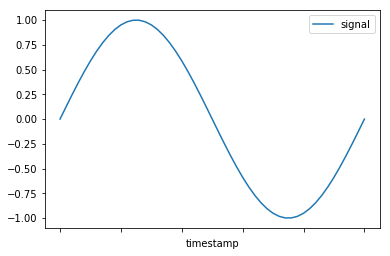

In [3]:
%matplotlib inline
import pandas as pd
df = pd.DataFrame(raw_result)
df.plot('timestamp', 'signal')
df['signal'].describe()

# Modelling Internal States, Mechanisms and User Behavior
Let's now suppose we want to design a system with which an agent will interact with the intent of replicating the value of the previously defined `signal` in an internal state. The agent can read the current value of the `signal` and the current value of the internal state. And they can add or subtract any amount from the internal state.

First we redefine the `initial_conditions` object in order to add the internal state, which will call `follow`

In [4]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# List of all the states in the system and their initial conditions
# In the current version of SimCAD, `timestamp` is mandatory
# The `signal` state is the exogenous state that we'll model
initial_conditions = {
    'follow': float(1),
    'signal': float(0),
    'timestamp': '2018-01-01 00:00:00'
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Next, define the function that updates the `follow` state. As defined above, all it does is add or subtract an amount from the state.

In [5]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Definitions of functions that update internal states
# These functions must return a tuple containing the name of the state being updated and its new value
# As with the exogenous state update functions, the `s` argument contains a copy of the current values of all the states
# The argument `_input` contains a dictionary of inputs passed to the mechanisms by agents interacting with it 

#momentum term limiting my following
theta = .2 

# Definition of the function that updates the `follow` state
def add(step, sL, s, _input):
    y = 'follow'
    x = (s['follow'] + _input['value'])*(1-theta)+ theta*s['follow']+.01*np.random.randn() # All the state update function does is add to the `follow` state the `value` passed to it
    return (y, x)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

The policies of the agents that interact with the system through `mechanisms` are modelled as `BEHAVIORS`. In this example, we are modelling a simple behavior in which the agent reads the current state of the exogenous `signal` and of the internal state `follow` and compares them. The `return value` of the behavior function will be passed by the SimCAD engine as the `_input` argument of the mechanism

In [6]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Definitions of the Behavioral Models (or Behaviors for short) - functions that convey some information to mechanisms
# Behaviors must return a dictionary containing whatever information they should pass to the mechanism they relate to
# As with the state update functions, the `s` argument contains a copy of the current values of all the states

# Definition of the `tracker` behavior
def tracker(step, sL, s):
    currentSignal = s['signal'] # Read the current state of the exogenous `signal`
    currentFollow = s['follow'] # Read the current state of the internal state `follow`
    diff = currentSignal - currentFollow # Compare the two
    return {'value': diff} # Return the difference between them

Finally, we map mechanisms to states and behaviors. In our example, we define that a mechanism called `simple_mechanism` updates the `follow` state through the `add` function, driven by the `tracker` behavior.

In [7]:
mechanisms = {
    'simple_mechanism': { # The name of the mechanism; can be anything
        'behaviors': { # Dictionary of behavioral models related to this mechanism
            'behavior_group_1': tracker # The name of the behavior (key), followed by the function that defines it
        },
        'states': { # Dictionary of states updated by this mechanism
            'follow': add # The name of the state (key) followed by the function that updates it
        }
    }
}

# Running the engine
We can now recreate the Configuration object and rerun the experiment with the expanded configurations

In [8]:
config = Configuration(sim_config=sim_config,
                       state_dict=initial_conditions,
                       seed=seeds,
                       exogenous_states=exogenous_states,
                       env_processes=env_processes,
                       mechanisms=mechanisms)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.main() # The `main()` method returns a tuple; its first elements contains the raw results

single_proc: [<SimCAD.configuration.Configuration object at 0x10fe77eb8>]


# Analyzing the results
And again we convert the raw results into a DataFrame for analysis

,signal,follow
count,5.100000e+01,51.000000
mean,-2.493893e-17,0.024362
std,7.071068e-01,0.719889
min,-9.980267e-01,-1.008295
25%,-6.845471e-01,-0.683094
50%,0.000000e+00,0.131055
75%,6.845471e-01,0.722606
max,9.980267e-01,1.013597


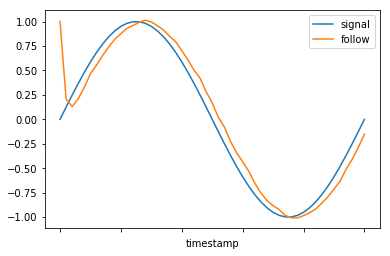

In [9]:
%matplotlib inline
import pandas as pd
df = pd.DataFrame(raw_result)
df.plot('timestamp', ['signal','follow'])
df[['signal','follow']].describe()

In [10]:
df["error"]= df.follow-df.signal

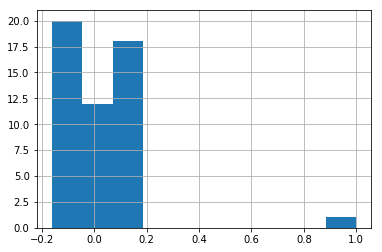

In [11]:
df.error.hist()